In [78]:
from langgraph.graph import StateGraph, END
from langchain.chat_models import ChatOpenAI
from langchain_core.runnables import RunnableLambda
from langchain_core.messages import HumanMessage

In [79]:
import os
from dotenv import load_dotenv
load_dotenv()
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [80]:
from typing import Optional
from typing_extensions import TypedDict


class CodeReviewState(TypedDict):
    code: str
    summary:str
    review:str
    suggestions:str

In [2]:
from langchain_groq import ChatGroq
llm=ChatGroq(model="qwen-qwq-32b")
llm.invoke("Hello").content

'\n<think>\nOkay, the user said "Hello". I need to respond in a friendly and engaging way. Let me start with a greeting. Maybe "Hello!" to keep it simple.\n\nI should ask how they\'re doing today. That shows I care. So, "How are you today?" \n\nThen, offer help with anything they might need. Something like, "Is there anything I can assist you with?" \n\nWait, maybe I can make it a bit more conversational. Let me check the example response they provided. The example was: "Hello! How are you today? Is there anything I can assist you with?" That\'s concise and friendly. \n\nHmm, maybe add a bit more warmth. Perhaps add an emoji? The example didn\'t use any, but maybe a smiley face? Or keep it text-only as per their example. Since they used plain text, I\'ll stick to that. \n\nAlternatively, could I phrase it differently? "Hello! How\'s your day going so far? Can I help you with anything?" But the example is shorter. \n\nI think the example response is good. Let me just use that structure.

In [82]:
def summarize_code(state: CodeReviewState):
    prompt = f"Analyze this Python code and summarize what it does:\n```python\n{state['code']}\n```"
    summary = llm.invoke([HumanMessage(content=prompt)]).content
    return {"summary": summary}

In [83]:
def review_code(state: CodeReviewState):
    prompt = f"Review the following Python code for bugs, security issues, best practices, and efficiency:\n```python\n{state['code']}\n```"
    review = llm.invoke([HumanMessage(content=prompt)]).content
    return {"review": review}


In [84]:
def suggest_fixes(state: CodeReviewState):
    prompt = f"Based on this review:\n{state['review']}\n\nProvide actionable suggestions to improve the code. Rewrite the improved version if needed."
    suggestions = llm.invoke([HumanMessage(content=prompt)]).content
    return {"suggestions": suggestions}

In [85]:
graph = StateGraph(CodeReviewState)

graph.add_node("summarize_code", summarize_code)
graph.add_node("review_code", review_code)
graph.add_node("suggest_fixes", suggest_fixes)

graph.set_entry_point("summarize_code")
graph.add_edge("summarize_code", "review_code")
graph.add_edge("review_code", "suggest_fixes")
graph.set_finish_point("suggest_fixes")

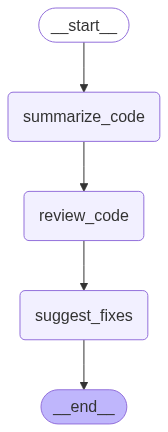

In [86]:
from IPython.display import Image
code_review_agent = graph.compile()
Image(code_review_agent.get_graph().draw_mermaid_png())

In [93]:
state = {"code": "def add(a, b):\n    return a + b"}

result = code_review_agent.invoke(state)
type(result)

langgraph.pregel.io.AddableValuesDict

In [94]:
print(result["summary"])
print(result["review"])



<think>
Okay, let's see. The user asked me to analyze this Python function and summarize what it does. The function is called add and takes two parameters, a and b. The code inside just returns a + b.

Hmm, first, I should think about the basics here. The function's name is 'add', which suggests it's for addition. The parameters a and b are the two numbers to be added. But wait, in Python, the parameters can actually be any type as long as the + operator is defined for them. So this function isn't limited to numbers. Oh right, because in Python you can add strings, lists, tuples, etc. using the + operator. So the function's purpose is to return the sum of a and b, but it's not restricted to numerical addition.

Wait, but the user might be expecting a basic explanation first. Let me start by stating that it adds two numbers. Then mention that it's more general because it can work with any data types that support the addition operation. For example, if a and b are integers, it adds them